In [7]:
import pandas as pd
# ensure that all columns are shown and that colum content is not cut
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width',1000)
pd.set_option('display.max_rows', 500) # ensure that all rows are shown

# `IncomeStatementStandardizer`

In the `07_00_stanardizer_basics.ipynb` we looked at the basic principles of the standardizer. And now we are going to explore the details of the `IncomeStatementStandardizer`.

## Main Goal
The main Goal of the `IncomeStatementStandardizer` is to provide a consilidated, standardized view that contains the main positions of an income statement.

The current implementation tries to find/calculate the values for the following positions:

<pre>
  Revenues
- CostOfRevenue
---------------
= GrossProfit
- OperatingExpenses
-------------------
= OperatingIncomeLoss

  IncomeLossFromContinuingOperationsBeforeIncomeTaxExpenseBenefit
- AllIncomeTaxExpenseBenefit
----------------------------
= IncomeLossFromContinuingOperations
+ IncomeLossFromDiscontinuedOperationsNetOfTax
-----------------------------------------------
= ProfitLoss
- NetIncomeLossAttributableToNoncontrollingInterest
---------------------------------------------------
= NetIncomeLoss
</pre>

**Note:**
- IncomeLossFromContinuingOperationsBeforeIncomeTaxExpenseBenefit is shorter name forfrom IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest
- AllIncomeTaxExpenseBenefit is not an official tag and is the sum of IncomeTaxExpenseBenefit and DeferredIncomeTaxExpenseBenefit
- IncomeLossFromContinuingOperations is not an officla tag and is calculated as shown above

**Important:** 
Most reports do not contain all the above tags. So the tags are calculated/defined to following main rules (Note, there are more rules, that are actually applied):
- If Revenues and/or CostOfRevenue could not be inferred from the data, CostOfRevenue is set to 0.0 and Revnues is set to GrossProfit
- If GrossProfit is not present or cannot be calculated from Revenues - CostOfRefenue
  calculate from GrossProfit from OperatingIncomeLoss + OperatingExpenses. If OperatingIncomeLoss is present, but no OperatingExpenses could be inferred, set GrossProfit to OperatingIncomeLoss
- If ProfitLoass is not present, calculate it from IncomeLossFromContinuingOperations + IncomeLossFromDiscontinuedOperationsNetOfTax
- If ProfitLoss is not present, calculate it from NetIncomeLoss + NetIncomeLossAttributableToNoncontrollingInterest. If NetIncomeLossAttributableToNoncontrollingInterest is not present, set ProfitLoss to NetIncomeLoss
- If NeetIncomeLoss is not present, calculate it from ProfitLoss - NetIncomeLossAttributableToNoncontrollingInterest. If NetIncomeLossAttributableToNoncontrollingInterest is not present, set NetIncomeLoass to ProfitLoss

## Prepare the dataset

As input, we are going to use the dataset which was created with the `06_bulk_data_processing_deep_dive.ipynb`. That dataset contains all available data for balance sheets. The path to this dataset - on my machine - is either `set/parallel/IS/joined` or `set/serial/IS/joined` depending whether it was produced with the faster parallel or slower serial processing approach.

The data is already filtered for 10-K and 10-Q reports. Moreover, the following filters were applied as well: `ReportPeriodRawFilter`, `MainCoregRawFilter`, `OfficialTagsOnlyRawFilter`, `USDOnlyRawFilter`. The dataset is already joined, so we can use it directly with the `IncomeStatementStandardizer`.

Of course, if you prefer another dataset, for instance all data of a few companies, or all data of a single year, feel free to do so.


    # As an alternative, using the data of a single year
    from secfsdstools.d_container.databagmodel import JoinedDataBag
    from secfsdstools.e_collector.zipcollecting import ZipCollector
    from secfsdstools.u_usecases.bulk_loading import default_postloadfilter

    collector = ZipCollector.get_zip_by_names(names=["2022q1.zip", "2022q2.zip", "2022q3.zip", "2022q4.zip"], 
                                              forms_filter=["10-K", "10-Q"],                                        
                                              stmt_filter=["IS"], post_load_filter=default_postloadfilter)

    all_is_joinedbag: JoinedDataBag = collector.collect().join()
    
    from secfsdstools.d_container.databagmodel import JoinedDataBag
    from secfsdstools.f_standardize.is_standardize import IncomeStatementStandardizer

    is_standardizer = IncomeStatementStandardizer()

    # standardize the data
    all_is_joinedbag.present(is_standardizer)    

This might take 30-60 seconds, depending on your hardware.

In [8]:
from secfsdstools.d_container.databagmodel import JoinedDataBag
from secfsdstools.f_standardize.is_standardize import IncomeStatementStandardizer

all_is_joinedbag:JoinedDataBag = JoinedDataBag.load(target_path="set/parallel/IS/joined")
is_standardizer = IncomeStatementStandardizer()

# standardize the data
all_is_joinedbag.present(is_standardizer)

,adsh,cik,name,form,fye,fy,fp,date,coreg,report,ddate,uom,qtrs,Revenues,CostOfRevenue,GrossProfit,OperatingExpenses,OperatingIncomeLoss,IncomeLossFromContinuingOperationsBeforeIncomeTaxExpenseBenefit,AllIncomeTaxExpenseBenefit,IncomeLossFromContinuingOperations,IncomeLossFromDiscontinuedOperationsNetOfTax,ProfitLoss,NetIncomeLossAttributableToNoncontrollingInterest,NetIncomeLoss,RevCogGrossCheck_error,RevCogGrossCheck_cat,GrossOpexpOpil_error,GrossOpexpOpil_cat,ContIncTax_error,ContIncTax_cat,ProfitLoss_error,ProfitLoss_cat,NetIncomeLoss_error,NetIncomeLoss_cat
505377,0001096906-21-001168,1089297,NOVAGANT CORP,10-K,1231,2004.0,FY,2004-12-31,,4,20041231,USD,4,0.000000e+00,0.000000e+00,0.000000e+00,2.100000e+01,-2.100000e+01,-2.100000e+01,0.0,-2.100000e+01,0.0,-2.100000e+01,0.0,-2.100000e+01,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
505378,0001096906-21-001172,1089297,NOVAGANT CORP,10-K,1231,2005.0,FY,2005-12-31,,4,20051231,USD,4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
505381,0001096906-21-001180,1089297,NOVAGANT CORP,10-K,1231,2006.0,FY,2006-12-31,,4,20061231,USD,4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
505382,0001096906-21-001182,1089297,NOVAGANT CORP,10-K,1231,2007.0,FY,2007-12-31,,4,20071231,USD,4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
66793,0001079974-15-000278,1454510,LNPR GROUP INC.,10-K,1231,2008.0,FY,2008-10-31,,4,20081031,USD,4,NaN,NaN,NaN,NaN,NaN,-2.547600e+04,0.0,-2.547600e+04,0.0,-2.547600e+04,0.0,-2.547600e+04,NaN,NaN,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516943,0001050825-23-000159,1050825,STEELCASE INC,10-Q,0228,2024.0,Q2,2023-08-31,,2,20230831,USD,1,8.546000e+08,5.698000e+08,2.834000e+08,2.359000e+08,4.100000e+07,3.700000e+07,9500000.0,2.750000e+07,0.0,2.750000e+07,0.0,2.750000e+07,0.001638,1.0,0.022936,5.0,0.0,0.0,0.000000,0.0,0.0,0.0
516942,0000866729-23-000028,866729,SCHOLASTIC CORP,10-Q,0531,2024.0,Q1,2023-08-31,,2,20230831,USD,1,2.285000e+08,1.300000e+08,9.850000e+07,1.976000e+08,-9.910000e+07,-9.800000e+07,-23800000.0,-7.420000e+07,0.0,-7.420000e+07,0.0,-7.420000e+07,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
516915,0001193125-23-238563,40704,GENERAL MILLS INC,10-Q,0531,2024.0,Q1,2023-08-31,,2,20230831,USD,1,4.904700e+09,3.134200e+09,1.770500e+09,8.405000e+08,9.300000e+08,8.535000e+08,196700000.0,6.568000e+08,0.0,6.803000e+08,6800000.0,6.735000e+08,0.000000,0.0,0.000000,0.0,0.0,0.0,0.034544,5.0,0.0,0.0
517099,0001628280-23-033300,920760,LENNAR CORP /NEW/,10-Q,1130,2023.0,Q3,2023-08-31,,4,20230831,USD,3,2.326518e+10,0.000000e+00,2.326518e+10,2.015036e+10,3.114823e+09,3.418235e+09,824233000.0,2.594002e+09,0.0,2.594002e+09,16778000.0,2.577224e+09,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


First, we will save the results, including all the logs, so that we can use the data directly in the future, without the need to process it again.<br>

In [3]:
import os
target_path = "standardized/IS"
os.makedirs(target_path, exist_ok=True)

is_standardizer.get_standardize_bag().save(target_path)

## Load the dataset
Once the data has been processed and saved, you can load it directly with the following code.

In [9]:
from secfsdstools.f_standardize.standardizing import StandardizedBag

is_standardizer_result_bag = StandardizedBag.load("standardized/IS")

## Overview

Before we dive into what the `IncomeStatementStandardizer` does in detail, lets get a first impression of the the produced data. First, let us see how many rows we have.

In [10]:
print("income statements: ", len(is_standardizer_result_bag.result_df))
print("filed reports: ", len(is_standardizer_result_bag.result_df.adsh.unique()))

income statements:  527970
filed reports:  319367


While we have about 320'000 reports (which is also about the same number of balance sheets, which we analyzed in notebook 07_01_BS_standardizer), we have around 530'000 Income Statements. Why is that?

An income statement shows the results of time period. For instance, the annual report (10-K) shows the revenue that was made during the whole year. Also, the quarterly report (10-Q) for the first (column `fp=Q1`) quarter shows the revenue that were made in the three months for the first quarter. However, things are differently for the second and third quarter.

Often, but not always, when company reports their results for Q2 and Q3, they not only report the results for the quarter itself, but also for period since the beginning of the financial year. That means, the income statement for Q2 will actually have 2 columns, one titled with "3 months ended" (which only shows the results for the quarter itself, and one column titled "6 months ended" (which contains the combined results of quarter 1 and 2.

This is actually indicated by the "qtrs" column. If this column is 1, it means the data is just for a single quarter, if it is 2, it means the data is for two quarters, and so on. So obviously, if column `fp=Q1`, you will only find entries with `qtrs=1`. If `fp=Q2` you will find entries with `qtrs=1` and `qtrs=2`. If `fp=Q3`, you will find entries with `qtrs=1` and `qtrs=3`.

This is also true for annual reports: `fp=FY`. Sometimes not just the results for the whole year are shown (`qtrs=4`), but also the results for the just the fourth quarter. 

However, even if most companies to report in Q2 and Q3 the results for the quarter itself and the results since beginning of the fiscal year, not all companies do that. Some do only report the results for the quarter itself, or only the results since the beginning of the fiscal year. 

Therefore, when comparing quaterly results, we always have to consider the period for which the data is presented. Moreover, you also have to look at the season that is included, For instance, Apple's Q1 includes the xmas season, for Samsung, xmas falls into its Q4.

Next, a good idea is to look at the `validation_overview_df`. This table gives an idea about the "quality" of the dateset based on the summary of the results of the applied validation rules.

In [11]:
is_standardizer_result_bag.validation_overview_df

,RevCogGrossCheck_cat,GrossOpexpOpil_cat,ContIncTax_cat,ProfitLoss_cat,NetIncomeLoss_cat,RevCogGrossCheck_cat_pct,GrossOpexpOpil_cat_pct,ContIncTax_cat_pct,ProfitLoss_cat_pct,NetIncomeLoss_cat_pct
0,490703,461165,506189,459467,517547,92.94,87.35,95.87,87.03,98.03
1,1487,1585,2170,13373,2529,0.28,0.30,0.41,2.53,0.48
5,725,1742,2718,15908,2339,0.14,0.33,0.51,3.01,0.44
10,510,925,1449,7998,1316,0.10,0.18,0.27,1.51,0.25
100,2462,13873,9918,26740,4239,0.47,2.63,1.88,5.06,0.80


This seems to be quite ok, since we have around 90% of the data in the first two to three categories. As a reminder, Category 0 means it is an exact match, catagory 1 means that it is less than 1 percent off the expected value (see notebook `07_00_standardizer_basics.ipynb` for details).

## Analysis on the whole dataset
The following examples are just some ideas to show, what we can do now with the standardized income statement dataset.

First let us have a look at the distribution of GrossProfit with a box plot.

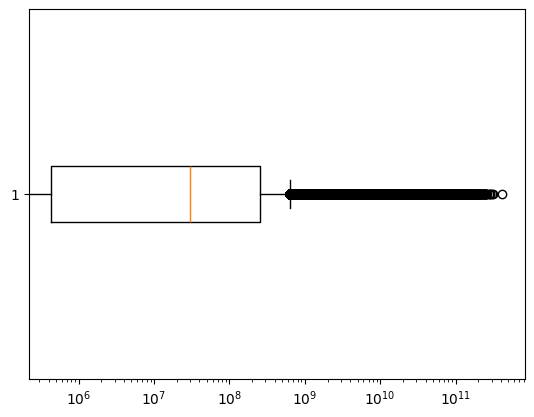

In [12]:
import matplotlib.pyplot as plt
data = is_standardizer_result_bag.result_df.GrossProfit
data = data[~data.isnull()]

plt.boxplot(data, vert=False)
plt.xscale('log') # using a logarithmic scale, we will lose negativ values though

Let's figure out, which report has the highest GrossProfit and then try to show the history of the GrossProfit for that company.

In [13]:
is_standardizer_result_bag.result_df[is_standardizer_result_bag.result_df.GrossProfit == is_standardizer_result_bag.result_df.GrossProfit.max()]

,adsh,cik,name,form,fye,fy,fp,date,coreg,report,ddate,uom,qtrs,Revenues,CostOfRevenue,GrossProfit,OperatingExpenses,OperatingIncomeLoss,IncomeLossFromContinuingOperationsBeforeIncomeTaxExpenseBenefit,AllIncomeTaxExpenseBenefit,IncomeLossFromContinuingOperations,IncomeLossFromDiscontinuedOperationsNetOfTax,ProfitLoss,NetIncomeLossAttributableToNoncontrollingInterest,NetIncomeLoss,RevCogGrossCheck_error,RevCogGrossCheck_cat,GrossOpexpOpil_error,GrossOpexpOpil_cat,ContIncTax_error,ContIncTax_cat,ProfitLoss_error,ProfitLoss_cat,NetIncomeLoss_error,NetIncomeLoss_cat
15837,0000034088-23-000020,34088,EXXON MOBIL CORP,10-K,1231,2022.0,FY,2022-12-31,,3,20221231,USD,4,4.136800e+11,0.0,4.136800e+11,3.708600e+11,4.282000e+10,7.775300e+10,2.017600e+10,5.757700e+10,0.0,5.757700e+10,1.837000e+09,5.574000e+10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Since we used the `present` method of the standardizer, the cik, form, fye, fy, and fp attributes from the sub_df were directly merged in the result. Also a `date` column with a date datatype was added and the data is already sorted by date.

Next, get all reports for this company and filter our standardized income statement data for it. 
We will show this as a barchart, and for the quarterly reports, we will us the data that contains the results from the beginning of the financial year (for Q2 we use qtrs=2 and for Q3 we use qtrs=3). This means, we will see the growth of GrossProfit during the year. 

In [20]:
mask_34088 = is_standardizer_result_bag.result_df.cik==34088
mask_FY = (is_standardizer_result_bag.result_df.fp=="FY") & (is_standardizer_result_bag.result_df.qtrs==4)
mask_Q1 = is_standardizer_result_bag.result_df.fp=="Q1"
mask_Q2 = (is_standardizer_result_bag.result_df.fp=="Q2") & (is_standardizer_result_bag.result_df.qtrs==2)
mask_Q3 = (is_standardizer_result_bag.result_df.fp=="Q3") & (is_standardizer_result_bag.result_df.qtrs==3)

reports_of_34088 = is_standardizer_result_bag.result_df[mask_34088 & (mask_FY | mask_Q1 | mask_Q2 | mask_Q3)]

In [21]:
reports_of_34088 = reports_of_34088[['date', 'GrossProfit', 'fp']].reset_index()

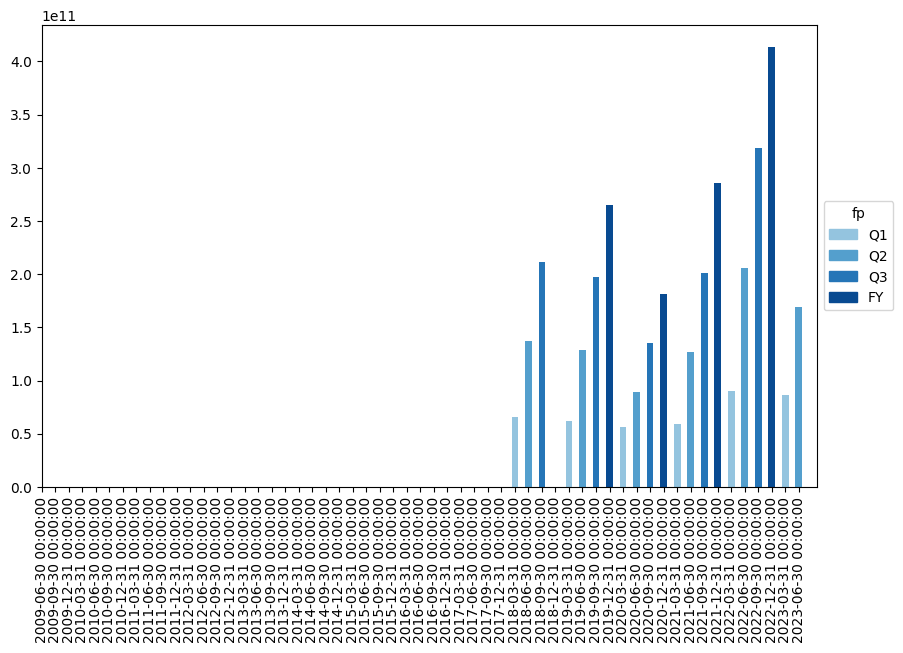

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# using fp to define the color
unique_fp = ['Q1', 'Q2', 'Q3', 'FY']
blues = plt.cm.Blues(np.linspace(0.4, 0.9, len(unique_fp)))
color_map = {fp: color for fp, color in zip(unique_fp, blues)}

# create bar chart
plt.figure(figsize=(10, 6)) 

# calculate bar width
bar_width = 2.0 / len(reports_of_34088['fp'].unique())

for index, row in reports_of_34088.iterrows():
    # add bars in the right color
    plt.bar(index, row['GrossProfit'], width=bar_width, color=color_map[row['fp']], label=row['fp'])

# add legend
legend_labels = [plt.Rectangle((0,0),1,1, color=color_map[fp]) for fp in unique_fp]
plt.legend(legend_labels, unique_fp, title='fp', loc='center left', bbox_to_anchor=(1, 0.5))

# x-axis labels
plt.xticks(range(len(reports_of_34088)), reports_of_34088['date'], rotation=90)

# show diagramm
plt.show()

Let us visualize some data for apple: -> cik 320193

But this time, we will just visualze the data for the annual reports.

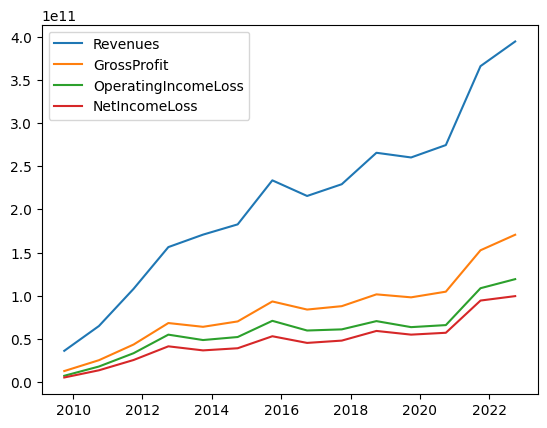

In [23]:
import matplotlib.pyplot as plt
apple_reports_df = is_standardizer_result_bag.result_df[(is_standardizer_result_bag.result_df.cik==320193) & mask_FY]

# Plotting
plt.plot(apple_reports_df['date'], apple_reports_df['Revenues'], label='Revenues', linestyle='-')
plt.plot(apple_reports_df['date'], apple_reports_df['GrossProfit'], label='GrossProfit', linestyle='-')
plt.plot(apple_reports_df['date'], apple_reports_df['OperatingIncomeLoss'], label='OperatingIncomeLoss', linestyle='-')
plt.plot(apple_reports_df['date'], apple_reports_df['NetIncomeLoss'], label='NetIncomeLoss', linestyle='-')
plt.legend()


### Compare companies

Let's visualize and compare the history of the GrossProfit for a few companies. We just use the yearly reports.

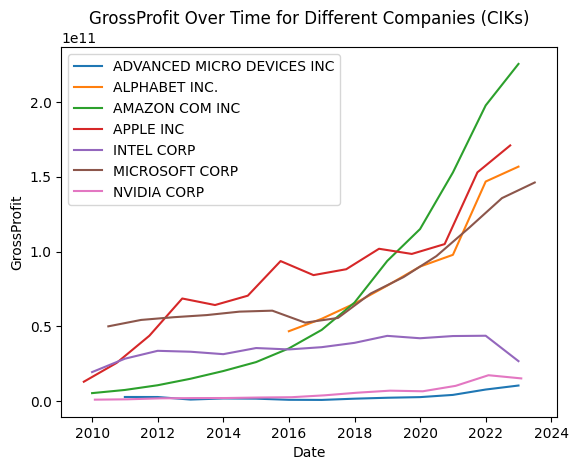

In [24]:
ciks_to_consider = [320193, 789019, 1652044, 1045810, 1018724, 2488, 50863] # Apple, Microsoft, Alphabet, nvidia, Amazon, AMD, intel

df = is_standardizer_result_bag.result_df[is_standardizer_result_bag.result_df.cik.isin(ciks_to_consider) & mask_FY].copy()

# Group by 'name' and plot GrossProfit for each group
# Note: using the `present` method ensured that the same cik has always the same name even if the company name did change in the past
for name, group in df.groupby('name'):
    plt.plot(group['date'], group['GrossProfit'], label=name, linestyle='-')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('GrossProfit')
plt.title('GrossProfit Over Time for Different Companies (CIKs)')

# Display legend
plt.legend()

Cloud providers seem to do exceptionally well these days: alphabet, amazon, and microsoft almost have an exponential grow in GrossProfit.

### Conclusion

With the Income Statement Standardizer, we have the possibility to actually compare data between companies and also to create input for ML models. 

The great thing is, that we can do this with official and free data of over 300'000 reports filed by about 14'000 companies since 2010 (by end of 2023).

Thanks to secfsdstools package, we have the possibility to gather and filter the data in a simple and efficient way, which otherwise would only be possible if you pay for the data. And you have all the data on your computer, no need for slow api calls.

The Standardizer framework is simple and can be extended with additional rules to make other data points available. With the validation rules we also have a way to assess the quality of single rows in the dataset.

Of course, calculating financial ratios based on the standardized dataset is really simple now.

Also the size of the standardized dataset (about 40MB) is really easy to handle.

## Rules

**Note:** 

**The following section tries to explain how the results are calculated and what kind of rules are applied. It isn't really necessary to understand this section in detail, but it gives you an idea what happens under the hood.**

Let us see how often which rule was applied. This gives an idea about how much "calculation" had to be done in order to create a standardized dataset. We can to this by looking at the `applied_rules_sum_s` pandas Series object.

(If you compare it to the 'BalanceSheetStandardizer, you see that there are more rules in the 'IncomeStatementStandardizer')

### How often was a rule applied

In [25]:
is_standardizer_result_bag.applied_rules_sum_s

0
NaN                                                                                                                                                                                                   0
PREPIVOT_IS_PREPIV_#1_DeDup                                                                                                                                                                       42219
PREPIVOT_IS_PREPIV_#2_CorSign                                                                                                                                                                     14760
MAIN_1_IS_#1_Rev_#1_Pre_#1_SalesRevenueGoodsNet<-SalesRevenueGoodsGross                                                                                                                            1811
MAIN_1_IS_#1_Rev_#1_Pre_#2_SalesRevenueServicesNet<-SalesRevenueServicesGross                                                                                                                      173

### Applied Rules
To be able to assess the content of `applied_rules_sum_s`  we need to understand the rules that are applied. The simplest way to do this is to print the description of them:

In [26]:
is_standardizer_result_bag.process_description_df

,part,type,ruleclass,identifier,description
0,PREPIVOT,Group,,PREPIVOT_IS_PREPIV,
1,PREPIVOT,Rule,PrePivotDeduplicate,PREPIVOT_IS_PREPIV_#1_DeDup,"Deduplicates the dataframe based on the columns ['adsh', 'coreg', 'report', 'ddate', 'uom', 'qtrs', 'tag', 'version', 'value']"
2,PREPIVOT,Rule,PrePivotCorrectSign,PREPIVOT_IS_PREPIV_#2_CorSign,"Ensures that the tags ['CostOfGoodsSold', 'CostOfServices', 'CostOfGoodsAndServicesSold', 'CostOfRevenue', 'CostOfGoodsSoldExcludingDepreciationDepletionAndAmortization', 'CostOfGoodsSoldDepreciationDepletionAndAmortization', 'CostOfGoodsSoldDepletion', 'CostOfGoodsSoldDepreciation', 'CostOfGoodsSoldAmortization', 'CostOfGoodsSoldDepreciationAndAmortization', 'CostOfGoodsSoldDirectFinancingLease', 'CostOfGoodsSoldElectric', 'CostOfGoodsSoldDirectMaterials', 'CostOfGoodsSoldDirectLabor', 'CostOfGoodsSoldOverhead', 'CostOfGoodsSoldOilAndGas', 'CostOfGoodsSoldSubscription', 'CostOfGoodsSoldDirectTaxesAndLicensesCosts', 'CostOfGoodsSoldMaintenanceCosts', 'CostOfGoodsSoldSalesTypeLease', 'CostOfServicesExcludingDepreciationDepletionAndAmortization', 'CostOfServicesDepreciation', 'CostOfServicesDepreciationAndAmortization', 'CostOfServicesCatering', 'CostOfServicesAmortization', 'CostOfServicesOilAndGas', 'CostOfServicesDirectTaxesAndLicensesCosts', 'CostOfServicesMaintenanceCosts', 'CostOfServicesLicensesAndServices', 'CostOfServicesDirectLabor', 'CostOfServicesLicensesAndMaintenanceAgreements', 'CostOfServicesEnergyServices', 'CostOfServicesDirectMaterials', 'CostOfServicesEnvironmentalRemediation', 'CostOfServicesOverhead', 'CostOfGoodsAndServicesSoldDepreciationAndAmortization', 'CostOfGoodsAndServicesSoldAmortization', 'CostOfGoodsAndServicesSoldOverhead', 'CostOfGoodsAndServicesSoldDepreciation', 'CostOfGoodsAndServicesEnergyCommoditiesAndServices', 'CostOfGoodsAndServiceExcludingDepreciationDepletionAndAmortization'] have a positive value. Applied when the expectation of having a negative or positive value is not met"
3,PRE,Group,,PRE_IS_PRE,
4,MAIN,Group,,MAIN_IS,
5,MAIN,Group,,MAIN_IS_#1_Rev,
6,MAIN,Group,,MAIN_IS_#1_Rev_#1_Pre,Preparation rules which might be usable to estimate the revenue
7,MAIN,Rule,CopyTagRule,MAIN_IS_#1_Rev_#1_Pre_#1_SalesRevenueGoodsNet<-SalesRevenueGoodsGross,Copies the values from SalesRevenueGoodsGross to SalesRevenueGoodsNet if SalesRevenueGoodsGross is not null and SalesRevenueGoodsNet is nan
8,MAIN,Rule,CopyTagRule,MAIN_IS_#1_Rev_#1_Pre_#2_SalesRevenueServicesNet<-SalesRevenueServicesGross,Copies the values from SalesRevenueServicesGross to SalesRevenueServicesNet if SalesRevenueServicesGross is not null and SalesRevenueServicesNet is nan
9,MAIN,Rule,SumUpRule,MAIN_IS_#1_Rev_#1_Pre_#3_SalesRevenueNet,"Sums up the available values in the columns ['SalesRevenueGoodsNet', 'SalesRevenueServicesNet'] and ['OtherSalesRevenueNet'] into the column 'SalesRevenueNet'. Values from ['OtherSalesRevenueNet'] are only added, if at least one value in ['SalesRevenueGoodsNet', 'SalesRevenueServicesNet'] is present. 'SalesRevenueNet' must be nan."


Let's discuss them in more detail.

First, wie have 2 PrePivot Rules, the first one removes duplicated entries, the second on corrects the sign of the values for `CostOf..` tags. Inside the income statement, CostOf.. positions are usually shown as a positive value, so that Revenues - CostOf = GrossProfit. However, there are some datapoints in which CostOf tags are stored as a negative value. So this rule corrects them.

There a no Pre rules.

The main rules contais 3 different types of groups:
- **Pre** which contains some preparation and calculation that could then be used to set the actual value. Their identifier is something like `MAIN_IS_#1_Rev_#1_Pre_#1....`. <br> For instance, in the group `MAIN_IS_#1_Rev_#1_Pre` we have rules that try to calculate the tag `SalesRevenueNet` if it is not already set. Furthermore, we have a rule that sums up wellknown `Revenues` positions into the new tag `RevenuesSum`. Neither `SalesRevenueNet` nor `RevenuesSum` are tags that will be shown in the final output, however, the might be used to set the `Revenues` tag in the following `Set` group.
- **Set** contains rule that actually set a value that will be contained in the final dataframe. Most of the time this is a group that contains mainly 'CopyTag' rules. The order of the `CopyTag` rules in this group defines the precedence. <br> For instance, the group `MAIN_IS_#1_Rev_#2_Set` contains rules that could set the value of `Revenues` it isn't already present. The first rule in this group is `MAIN_IS_#1_Rev_#2_Set_#1_Revenues<-SalesRevenueNet` which will set `Revenues` to the value of `SalesRevenueNet`. Next, if there is no `SalesRevenueNet`, it uses `RevenueFromContractWithCustomerExcludingAssessedTax` to find a value for `Revenues`. Then it uses `RevenueFromContractWithCustomerIncludingAssessedTax`, .. and so on.
- **missing** In the financial statements, we often have a relation between tags like A - B = C, resp. A = B + C. For instance, `Revenues`- `CostOfRevenues` = `GrossProfit`. Which means, if only two of such a triple have a value, we can calculate the third one. The rules in a missing group do that. Every missing rule group has 3 rules, the first one calcualtes A by adding B and  C (A = B + C), the second calculates B bei subtracting C from A (B = A - C), and the third calculates C from subtracting B from A (C = A - B). <br> For example:<br>The group MAIN_IS_#3_RevCostGross_missing has three rules. The first is MAIN_IS_#3_RevCostGross_missing_#1_Revenues, which calculates missing Revenues by adding GrossProfit and CostOfRevenue. The second calculates missing CostOfRevenue by subtracting GrossProfit from Revenue, and finally, the third calculates missing GrossProfit by subtracting CostOfRevenue from Revenue.

Therefore, in most cases, the rules in the Pre group do not really have an effect. Results from the Pre-group rules can be used in the following Set rules, however, at most one single rule from the Pre-group might produce a value that is then used to set the actual value.

The first two rules in the **Post** rules correct the sign of IncomeTaxExpenseBenefit. Usually money that was spent to pay taxes appears a positive number, so that the equation IncomeLossFromContinuingOperationsBeforeIncomeTaxExpenseBenefit - AllIncomeTaxExpenseBenefit = ProfitLoss. If the rule discovers, that the equation IncomeLossFromContinuingOperationsBeforeIncomeTaxExpenseBenefit + AllIncomeTaxExpenseBenefit = ProfitLoss is true, the value of AllIncomeTaxExpenseBenefit is inverted.
The third Post rule corrects the sign of NetIncomeLossAttributableToNoncontrollingInterest if necessary. Again, we expect, that ProfitLoss - NetIncomeLossAttributableToNoncontrollingInterest = NetIncomeLoss is true.

The rest of the **Post** rules tries to complete still missing entries. For instance, some reports have as their last line the IncomeLossFromContinuingOperationsBeforeIncomeTaxExpenseBenefit. So neither ProfitLoss nor NetIncomeLoss is present. In this cases, we propagate the value down NetIncomeLoss.

There are five **Validation** rules that check if the following conditions of an income statement are met:

1. Revenues = CostOfRevenue + GrossProfit
2. GrossProfit = OperatingExpenses + OperatingIncomeLoss
3. IncomeLossFromContinuingOperationsBeforeIncomeTaxExpenseBenefit = AllIncomeTaxExpenseBenefit + IncomeLossFromContinuingOperations
4. ProfitLoss = IncomeLossFromContinuingOperations + IncomeLossFromDiscontinuedOperationsNetOfTax
5. ProfitLoss = NetIncomeLoss + NetIncomeLossAttributableToNoncontrollingInterest


The following overview tries to show the whole "algorithm" in textform:


      Main Rules
        Revenues:
            Pre
                + SalesRevenueGoodsNet     <- SalesRevenueGoodsGross
                + SalesRevenueServicesNet  <- SalesRevenueServicesGross
                + OtherSalesRevenueNet
                --------------
                = SalesRevenueNet


                RevenueFromContractWithCustomerIncludingAssessedTax
                - ExciseAndSalesTaxes
                ---------------------
                = RevenueFromContractWithCustomerExcludingAssessedTax


                + RegulatedAndUnregulatedOperatingRevenue
                + HealthCareOrganizationPatientServiceRevenue
                + ContractsRevenue
                + RevenueOilAndGasServices
                  ...
                ------------------
                = RevenuesSum

            Set
                1. Prio: Revenues
                2. Prio: SalesRevenueNet
                3. Prio: RevenueFromContractWithCustomerExcludingAssessedTax
                4. Prio: RevenueFromContractWithCustomerIncludingAssessedTax
                5. Prio: RevenuesExcludingInterestAndDividends
                6. Prio: RevenuesSum
                7. Prio: InvestmentIncomeInterest
                8. Prio: CostOfRevenue + GrossProfit


        CostOfRevenue

            Pre
                    + CostOfGoodsSoldExcludingDepreciationDepletionAndAmortization
                    + CostOfGoodsSoldDepreciationDepletionAndAmortization
                    + CostOfGoodsSoldDepletion
                    + CostOfGoodsSoldDepreciation
                    + ...
                    ------------
                    = CostOfGoodsSold (if not set)


                    + CostOfServicesExcludingDepreciationDepletionAndAmortization
                    + CostOfServicesDepreciation
                    + CostOfServicesDepreciationAndAmortization
                    + CostOfServicesCatering
                    + ...
                    ------------
                    = CostOfServices (if not set)


                    + CostOfGoodsAndServicesSoldDepreciationAndAmortization
                    + CostOfGoodsAndServicesSoldAmortization
                    + CostOfGoodsAndServicesSoldOverhead
                    + CostOfGoodsAndServicesSoldDepreciation
                    + CostOfGoodsAndServicesEnergyCommoditiesAndServices
                    + CostOfGoodsAndServiceExcludingDepreciationDepletionAndAmortizatio
                    ------------
                    = CostOfGoodsAndServicesSold (if not set)


                      CostOfGoodsSold
                    + CostOfServices
                    ---------------
                    = CostOfGoodsAndServicesSold (if not set)
         
            Set
                1. Prio CostOfRevenue
                2. Prio CostOfGoodsAndServicesSold
                3. Prio Revenues - GrossProfit

        GrossProfit

            1. Prio GrossProfit
            2. Prio Revenues - CostOfRevenue
            3. Prio GrossInvestmentIncomeOperating
            4. Prio InterestAndDividendIncomeOperating

        OperatingExpenses
        
            Pre
                + SellingGeneralAndAdministrativeExpense
                + GeneralAndAdministrativeExpense
                + ResearchAndDevelopmentExpense
                + SellingAndMarketingExpense
                + ... (96 most expense tags)
                ----------------------------
                = OperatingExpensesSum

            Set
                1. Prio OperatingExpenses
                2. Prio GrossProfit - OperatingIncomeLoss
                3. Prio OperatingExpensesSum


        OperatingIncomeLoss
            Set
            1. Prio OperatingIncomeLoss
            2. Prio GrossProfit - OperatingExpenses


        IncomeLossFromContinuingOperationsBeforeIncomeTaxExpenseBenefit
          Pre
              + IncomeLossFromContinuingOperationsBeforeIncomeTaxesMinorityInterestAndIncomeLossFromEquityMethodInvestments
              + (Optional) IncomeLossFromEquityMethodInvestments
              --------------------------------------------------
              = IncomeLossFromContinuingOperationsFromEquityMethodInvestements
          Set
              1. Prio IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest rename
              2. Prio IncomeLossFromContinuingOperationsFromEquityMethodInvestements
              3. Prio IncomeLossFromContinuingOperations + AllIncomeTaxExpenseBenefit
          

        NetIncome
           Pre
                + IncomeTaxExpenseBenefit
                + DeferredIncomeTaxExpenseBenefit
                + (optional) IncomeLossFromEquityMethodInvestments
                ---------------------------------
                = AllIncomeTaxExpenseBenefit
                
                
                IncomeLossFromContinuingOperations <- (rename) IncomeLossFromContinuingOperationsIncludingPortionAttributableToNoncontrollingInterest
                IncomeLossFromDiscontinuedOperationsNetOfTax <- (rename) IncomeLossFromDiscontinuedOperationsNetOfTaxAttributableToReportingEntity
                
                + IncomeLossFromContinuingOperationsBeforeIncomeTaxExpenseBenefit
                - AllIncomeTaxExpenseBenefit
                ---------------------------------
                = IncomeLossFromContinuingOperations
                
                
                + IncomeLossFromContinuingOperations
                + IncomeLossFromDiscontinuedOperationsNetOfTax
                -------------------------
                = ProfitLossParts
                              
           
           SetProfitLoss
                1. Prio ProfitLoss
                2. Prio ProfitLossParts
                3. Prio NetIncomeLoss
           
           SetIncomeLossContinuingOperations
                3. Prio ProfitLoss
           
           SetNetIncomeLoss
                1. Prio NetIncomeLoss
                2. Prio NetIncomeLossAvailableToCommonStockholdersBasic
                3. Prio NetIncomeLossAllocatedToLimitedPartners
                3. Prio ProfitLoss
                4. Prio ProfitLossIncludingRedeemableNonControllingInterest
                5. Prio OtherComprehensiveIncomeLossNetOfTax
                6. Prio ComprehensiveIncomeNetOfTax
                7. Prio IncomeLossAttributableToParent
                8. Prio NetInvestmentIncome
           

      Post Rule (Cleanup)
        Fix Sign of AllIncomeTaxExpenseBenefit (should be positive if taxed were paid)
            expected equation to be true:
               IncomeLossFromContinuingOperationsBeforeIncomeTaxExpenseBenefit - AllIncomeTaxExpenseBenefit = ProfitLoss

            invert sign of AllIncomeTaxExpenseBenefit if the following equation is true:
               IncomeLossFromContinuingOperationsBeforeIncomeTaxExpenseBenefit + AllIncomeTaxExpenseBenefit = ProfitLoss

        Fix sign of NetIncomeLossAttributableToNoncontrollingInterest
            expected equation to be true:
               ProfitLoss - NetIncomeLossAttributableToNoncontrollingInterest = NetIncomeLoss

            invert sign of NetIncomeLossAttributableToNoncontrollingInterest if the following equation is true:
               ProfitLoss + NetIncomeLossAttributableToNoncontrollingInterest = NetIncomeLoss

        If Revenues was not set, but there is a GrossProfit, set it to GrossProfit,
              since was no CostOfRevenue found

        If GrossProfit couldn't be set, but there is Revenues, set it to Revenues
              since was no CostOfRevenue found

        if CostORevenues couldn't be set, but Revenues and GrossProfit are present, set it to Revenues - Grossprofit

        if OperatingIncomeLoss is not set yet, and GrossProfit (available now) and OperatingExpenses are present,
             set it to GrossProfit - OperatingExpenses

        If there is no IncomeLossFromContinuingOperations, set it to ProfitLoss
        if there is no IncomeLossFromContinuingOperationsBeforeIncomeTaxExpenseBenefit, set it to IncomeLossFromContinuingOperations
        if there is no AllIncomeTaxExpenseBenefit, set it to IncomeLossFromContinuingOperationsBeforeIncomeTaxExpenseBenefit - AllIncomeTaxExpenseBenefit

        set IncomeLossFromDiscontinuedOperationsNetOfTax to 0.0 if not present

        If there is no IncomeLossFromContinuingOperations, set it to IncomeLossFromContinuingOperationsBeforeIncomeTaxExpenseBenefit
        If there is no ProfitLoss, set it to IncomeLossFromContinuingOperations + IncomeLossFromDiscontinuedOperationsNetOfTax
        If there is no NetIncomeLoss, set it to ProfitLoss
        If there is no NetIncomeLossAttributableToNoncontrollingInterest, set it to ProfitLoss - NetIncomeLoss


### Overview on applied rules
It might be interesting to know how many rules are applied in general per report. In this example, we just look at the MAIN and PRE rules:

In [27]:
# just use a shorter variable name
df=is_standardizer_result_bag.applied_rules_log_df

# we are just interested in the MAIN and PRE rules
filtered_columns = df.columns[df.columns.str.contains('MAIN|PRE')]

# count how many True values are in each row
df['count_true_values'] = df[filtered_columns].sum(axis='columns')

df.count_true_values.value_counts().sort_index()

0       883
1       805
2      2439
3      2931
4     14208
5     29743
6     50189
7     68122
8     87703
9     88046
10    91891
11    49260
12    24648
13    13509
14     3098
15      477
16       18
Name: count_true_values, dtype: int64

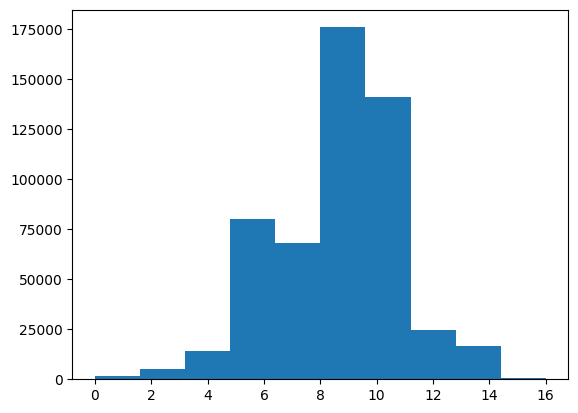

In [28]:
import matplotlib.pyplot as plt

plt.hist(df.count_true_values)

# Show the plot
plt.show()

### Showing the applied rules for a specific report number
If we analys a single report and want to know which rules were applied, we can do that with the following code:

In [29]:
apple_10k_2022 = "0000320193-22-000108"
apple_10k_2022_applied_rules_log_df = is_standardizer_result_bag.applied_rules_log_df[is_standardizer_result_bag.applied_rules_log_df.adsh==apple_10k_2022]

# filter for the applied MAIN,PRE, and POST rules
main_rule_cols =  df.columns[df.columns.str.contains('MAIN|PRE|POST')]
main_rule_df = apple_10k_2022_applied_rules_log_df[main_rule_cols]

# get the applied rules, by using the True and False values of main_rule_df.iloc[0] as a mask on the columns index
main_rule_df.columns[main_rule_df.iloc[0]].tolist()

['MAIN_1_IS_#1_Rev_#2_Set_#2_Revenues<-RevenueFromContractWithCustomerExcludingAssessedTax',
 'MAIN_1_IS_#2_CostOfRevenues_#2_Set_#1_CostOfRevenue<-CostOfGoodsAndServicesSold',
 'MAIN_1_IS_#6_OperatingExpenses_#1_Pre_#1_OperatingExpensesSum',
 'MAIN_1_IS_#7_netincome_#1_Pre_#1_IncomeLossFromContinuingOperationsBeforeIncomeTaxExpenseBenefit<-IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest',
 'MAIN_1_IS_#7_netincome_#1_Pre_#4_AllIncomeTaxExpenseBenefit',
 'MAIN_1_IS_#7_netincome_#1_Pre_#5_IncomeLossFromContinuingOperations',
 'MAIN_1_IS_#7_netincome_#1_Pre_#7_ProfitLossParts',
 'MAIN_1_IS_#7_netincome_#2_SetPL_#2_ProfitLoss<-NetIncomeLoss',
 'MAIN_1_IS_#9_NetIncomeLossAttributableToNoncontrollingInterest',
 'POST_IS_#11_IncomeLossFromDiscontinuedOperationsNetOfTax']

- **MAIN_1_IS_#1_Rev_#2_Set_#2_Revenues<-RevenueFromContractWithCustomerExcludingAssessedTax**: Apple reports its Revenue with the tag `RevenueFromContractWithCustomerExcludingAssessedTax`.
- **MAIN_1_IS_#2_CostOfRevenues_#2_Set_#1_CostOfRevenue<-CostOfGoodsAndServicesSold**: CostOfRevenues is reported with the tag `CostOfGoodsAndServicesSold`
- **MAIN_1_IS_#6_OperatingExpenses_#1_Pre_#1_OperatingExpensesSum**: is not relevant, since OperatingExpensesSum is never used to set a value
- **MAIN_1_IS_#7_netincome_#1_Pre_#1, .. MAIN_1_IS_#7_netincome_#1_Pre_#1**: are all not relevant, since none of the calculated values is used to set a value
- **MAIN_1_IS_#7_netincome_#2_SetPL_#2_ProfitLoss<-NetIncomeLoss**: Apple doesn't report the ProfitLoss position, so ProfitLoss receives the same value as NetIncomeLoss
- **MAIN_1_IS_#9_NetIncomeLossAttributableToNoncontrollingInterest**: will be set to zero, since ProfitLoss and NetIncomeLoss have the same value
- **POST_IS_POST_#11_IncomeLossFromDiscontinuedOperationsNetOfTax**: Apple didn't report any IncomeLoss from discontinued operations, so this value is set to 0.

Compare it to the real report: https://www.sec.gov/Archives/edgar/data/320193/000032019322000108/0000320193-22-000108-index.htm

As a conclusion, in the cas of apples 2022 annual report, we just rename entries to a standardized tag names, which is not critical. 